# **Modelling**

## Objectives

* Create dataset ready for ML modelling and dashboard
    + Remove small non hazardous asteroids
    + create classes based on features such as diameter, proximity and velocity.
    + save data to `features_modelled.csv`

## Inputs

* `features.csv` with adjustments suggested in conclusion to visualisations notebook to balance classes and aid modelling, principally:
    * introduce binned classes for very skewed features, particularly to aid building tree based models
    * Drop values (e.g. very small asteroids) to rebalance dataset, particularly in regard to our target value, hazardous status.
    * Suggest features to suit different models - e.g. log features for Logistic Regression, binned classes for Random Forest etc. 


## Outputs

* Dataset with only potentially hazardous asteroids(phas) included.
* Classes for major features to be used ML section and dashboard
* Saved dataset with new features and adjustments to `features_modelled.csv`






---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\Near-Earth-Asteroid-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\Near-Earth-Asteroid-Analysis'

# Remodelling Data

#### Objectives

To remodel data in line with summary at conclusion of `Visualistions.ipynb`
* Load data from `features.csv`
* Select target boundaries to drop values for low diameter & extremely distant asteroids prior to created binned features (so as not to distort ranges)
* Create binned classes for our very skewed features - display new distributions
* Check for consistency of data - features are better balanced, particularly for our target variable

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import plotly.graph_objects as go not sure will need this
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
## Load the processed features data
df = pd.read_csv('data/processed/features.csv')
df.head()

,name,est_diameter_min,est_diameter_max,relative_velocity_mean,miss_distance_mean,miss_distance_min,absolute_magnitude_mean,hazardous,observations,est_diameter_range,est_diameter_mean,est_diameter_min_log1p,est_diameter_max_log1p,est_diameter_mean_log1p,est_diameter_range_log1p,relative_velocity_mean_log1p,miss_distance_mean_log1p,miss_distance_min_log1p,hazardous_enc
0,(1983 LC),0.342417,0.765667,60192.646491,1.847664e+07,1.033448e+07,19.45,True,2,0.423250,0.554042,0.294472,0.568529,0.440859,0.352943,11.005322,16.732018,16.150996,1
1,(1986 NA),0.284810,0.636854,51810.077045,7.005246e+07,7.005246e+07,19.85,False,1,0.352044,0.460832,0.250611,0.492776,0.379006,0.301618,10.855359,18.064755,18.064755,0
2,(1988 NE),0.402305,0.899580,22815.738845,6.506331e+07,6.506331e+07,19.10,False,1,0.497276,0.650942,0.338117,0.641633,0.501346,0.403647,10.035250,17.990871,17.990871,0
3,(1989 AZ),0.319562,0.714562,55184.046572,2.560466e+07,2.021980e+07,19.60,False,2,0.395000,0.517062,0.277300,0.539158,0.416776,0.332895,10.918447,17.058285,16.822173,0
4,(1991 GO),0.265800,0.594347,92501.896829,3.695728e+07,2.702563e+07,20.00,True,2,0.328547,0.430073,0.235704,0.466464,0.357726,0.284086,11.434995,17.425273,17.112296,1


The first objective is to decide boundaries for dropping outlier data, for ranges which would not be considered hazardous and therefore add noise to the model with no gain. 
* Very small diameter asteroids
* Very distant asteroids

The threshold for asteroids to be considered potentially dangerous is 140m according to [NASA](https://cneos.jpl.nasa.gov/about/neo_groups.html), however we can check our data to find a reasonable boundary. I will check maximum and mean measures to see where the boundary is in the data.

In [6]:
# find minimum size of potentially hazardous objects checking both mean, min and max estimated diameter
hazardous_asteroids = df[df['hazardous'] == True]
min_size_hazardous = hazardous_asteroids[['est_diameter_mean', 'est_diameter_max', 'est_diameter_min']].min()
min_size_hazardous

est_diameter_mean    0.142411
est_diameter_max     0.196807
est_diameter_min     0.088015
dtype: float64

From this we can see that the measure of 140m holds - there are no hazardous asteroids with a mean diameter less than this.

In [7]:
#drop asteroids with mean diameter < 140m
df_model = df[df['est_diameter_mean'] >= 0.14]
df_model.shape, df.shape

((10155, 19), (27423, 19))

In [8]:
print(df['hazardous'].value_counts(), df_model['hazardous'].value_counts())

hazardous
False    25250
True      2173
Name: count, dtype: int64 hazardous
False    7982
True     2173
Name: count, dtype: int64


This has considerably reduced our dataset, whilst preserving our target data. While the scale of reduction may be quite extreme I believe it is justifed in terms of project/ business requirements.
* As our principal project aim is identifying potentially hazardous or impact-significant asteroids, then sub-140 m objects are essentially out of scope and add noise.
* They won’t be treated differently by hazard classifiers because they can’t be hazardous by definition.
* The decision aligns with the scope and aims of the model

Our next question is how to handle outliers for miss distance. Referring again to [NASA](https://cneos.jpl.nasa.gov/about/neo_groups.html) which classifies hazardous asteroids as  all asteroids with an Earth Minimum Orbit Intersection Distance (MOID) of 0.05 au or less (about 7.5million km). However we do not have orbital data, just a snapshot of proximity. Asteroids with extreme elliptical orbits may pass within this range but may also be observed at much greater distances. Let us check the data again.

In [9]:
# find maximum distances of potentially hazardous objects checking both mean and min distance
hazardous_asteroids = df[df['hazardous'] == True]
max_distance_hazardous = hazardous_asteroids[['miss_distance_mean', 'miss_distance_min']].max()
max_distance_hazardous

miss_distance_mean    7.470231e+07
miss_distance_min     7.470231e+07
dtype: float64

This is obviously quite a bit larger (10 times) than the measurement for MOID, suggesting asteroids with an eccentric or extreme orbit around earth - without orbital information we cannot say.

In [10]:
df['miss_distance_mean'].max(), df['miss_distance_min'].max()

(74798651.4521972, 74798651.4521972)

We can see from this that hazardous objects are found at the extreme end of distance scale and so there would be little value in dropping any values, other than to normalise skewed data. With this in mind we will proceed to creating binned classes for some of our data. First lets do a quick visual check.

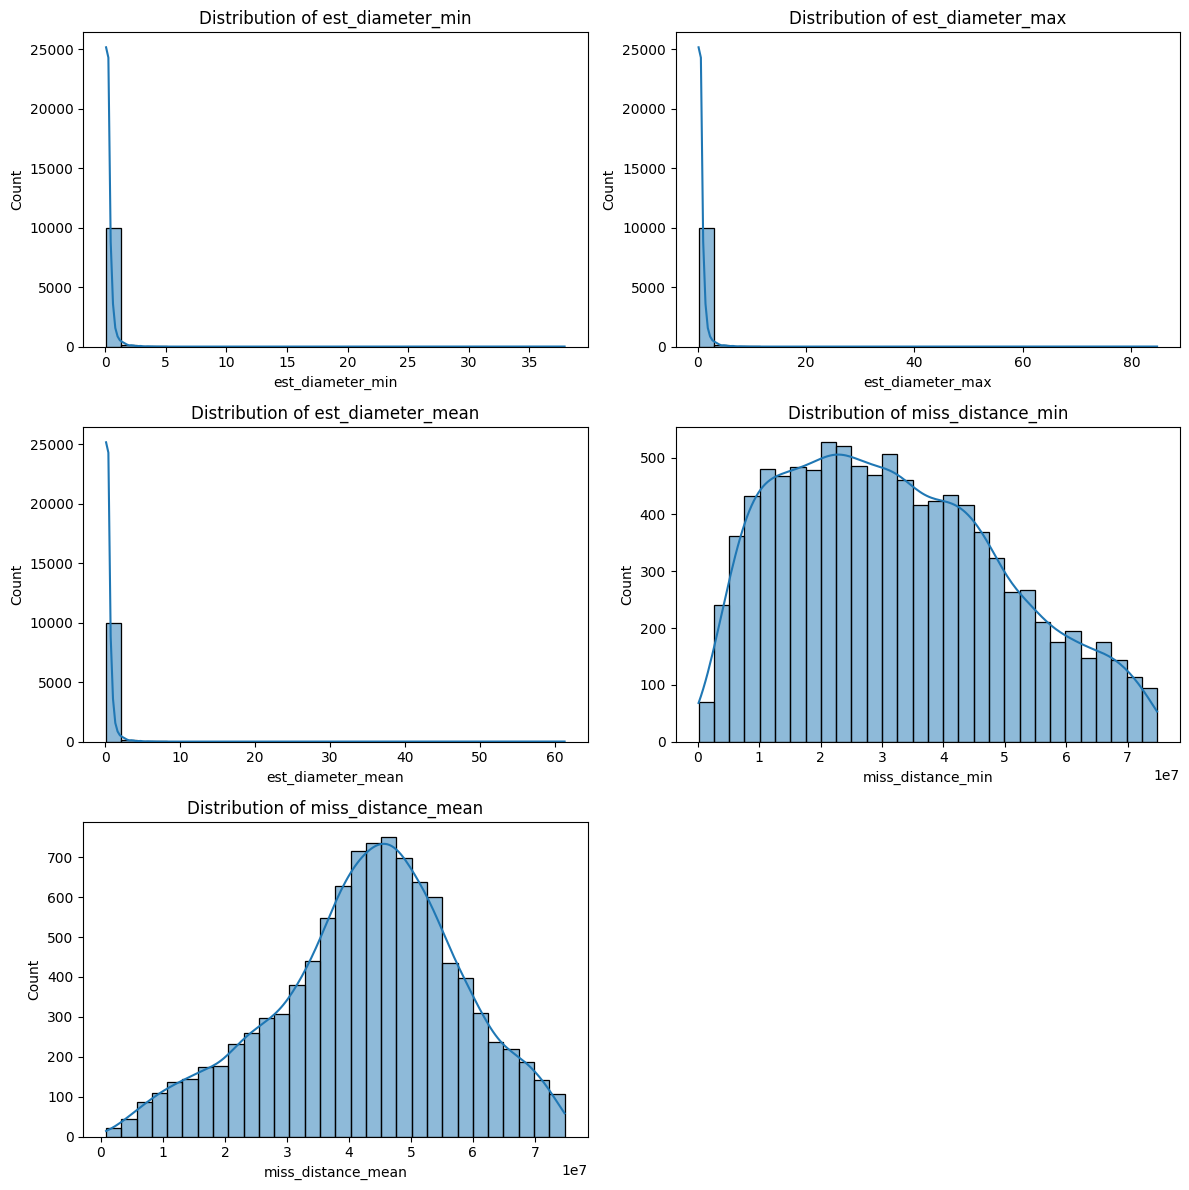

In [11]:
features = [
    "est_diameter_min", "est_diameter_max", "est_diameter_mean",
    "miss_distance_min", "miss_distance_mean"
]

plt.figure(figsize=(12, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_model[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

This confirms what our statistical tests our Visualisations notebook suggested - that large numbers of very small asteroids with small miss distances distorted the data - miss_distance now has much more normal distribution, even though values were dropped on the basis of size.

*Speculative Reason*
* Small asteroids tend to be observed more when they are close to earth?

In [12]:
##temp code
df_model.to_csv('Data/Processed/features_model.csv', index=False)

---

# Adding Classifiers

🌳 For Tree-based Models (e.g., Random Forest, XGBoost, LightGBM)

✅ Categorical encoding (like label encoding or one-hot) is usually best.

Why:

Tree models don’t care about feature scaling — they split on thresholds (e.g., “diameter_class ≤ medium”).

Binned or encoded categories help trees find discrete, interpretable splits (“moderate miss distance” vs “distant”).

Encoding preserves interpretability — and trees won’t get confused by the numeric scale.

#### **Feature Binning: Rationale & Process**

To improve model interpretability and handle the wide numeric ranges present in key features, continuous variables will be transformed into binned categorical classes. This approach mitigates the impact of skewed distributions (particularly for miss distance, estimated diameter and velocity) and helps the model capture non-linear effects more effectively.

The binning thresholds were chosen based on a combination of domain logic and data distribution analysis — for example, “very close” encounters (<2 million km) versus “distant” (>40 million km), or “small” (0.14–0.5 km) versus “large” (>5 km) diameters. These categories should preserve interpretive meaning while balances classes across bins.

Bins will be applied using consistent cutoffs to generate new features such as miss_distance_class, diameter_class and  velocity_class.  

In order to deal with the inverted scale of absolute_magnitude I also propose creating a brightness_class, with categories such "very bright", bright etc - or alternatively approach would be used an inverted scale.

I will also create a class for observations as there are wide range of values here. With over 40 observations for some objects, but only a few for most objects.


#### For Tree-based Models (e.g., Random Forest, XGBoost, LightGBM)

Tree models don’t care about feature scaling — they split on thresholds (e.g., “diameter_class ≤ medium”).

Binned or encoded categories help trees find discrete, interpretable splits (“moderate miss distance” vs “distant”).

Encoding preserves interpretability — and trees won’t get confused by the numeric scale.
These will later be encoded numerically (via label encoding) for use in tree model training.

#### For Linear Regression Models 

We can used our already existing log scaled features in this case - or alternativly use one-hot encoding on categories.



---

### Creating Classes ###

*  Diameter Classification
    + we have several measures of diameter - as we used `est_mean_diameter` for removing the smallest asteroids we will encode based on this class.

Diameter class 
* small	140 – 500m	
    * Small NEOs
    * capable of local damage if impacting Earth	
* medium 500m  – 1km	
    * Regional damage scale
    * Tunguska to Chelyabinsk-sized (large asteroid impacts)
* large	1km – 5km	
    * Regional to continental damage, capable of major impact
	* Fewer in number but highly significant risk category.
* very_large	5Km – 20km	
    * Global climatic effects possible upon impact	
    * Comparable to historical mass-impact events.
* giant	> 20km	
    * Planetary-scale catastrophic potential
    * Extremely rare — only a few known examples.

In [ ]:
# Define bin edges (adjustable depending on your analysis scope)
diameter_bins = [0.14, 0.5, 1, 5,  df_model["est_diameter_mean"].max()]
#removed 20km as upper limit as only 2 asteroids > 20km
# Define corresponding labels
diameter_labels = ["small", "medium", "large", "very_large"]
#removed 'huge' as only 2 asteroids > 20km
# Apply binning
df_model["diameter_class"] = pd.cut(
    df_model["est_diameter_mean"],
    bins=diameter_bins,
    labels=diameter_labels,
    include_lowest=True
)

# Summary of class distribution
print("Diameter Class Distribution:")
print(df_model["diameter_class"].value_counts(dropna=False))

Diameter Class Distribution:
diameter_class
small         7023
medium        2183
large          926
very_large      23
Name: count, dtype: int64


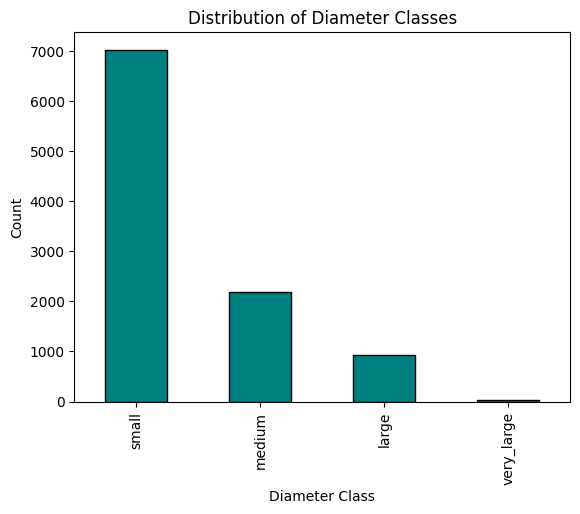

In [19]:
df_model["diameter_class"].value_counts().sort_index().plot(
    kind="bar", color="teal", edgecolor="black"
)
plt.title("Distribution of Diameter Classes")
plt.xlabel("Diameter Class")
plt.ylabel("Count")
plt.show()

*  Proximity Classification
    + we have two measures of miss_distance - as  `min_miss_distance` and `mean_miss_distance`. As min distance is based on a single observation for each object, therfore likely to have more fluctuatiing values, we will use mean to classify.


Proximity class (km)
* **extremely_close**	0 – 2 million	Very near-Earth encounters
* **close**	 2 – 10 million	Close but not immediate risk
* **medium**	10 – 40 million	Typical NEO flybys
* **distant**	40 – 55 million	Safely distant
* **very_distant**	> 55 million	Far flybys (minimal risk)

In [ ]:
# Define proximity bands
# These reflect roughly increasing encounter distance (in km)
proximity_bins = [0, 2e6,1e7, 4e7, 5.5e7, df_model["miss_distance_mean"].max()]

# Define *inverted* labels: closest → distant
proximity_labels = [ "extremely_close", "close", "medium", "distant", "very_distant"]

# Apply binning
df_model["proximity_class"] = pd.cut(
    df_model["miss_distance_mean"],
    bins=proximity_bins,
    labels=proximity_labels,
    include_lowest=True
)

# Quick check of class distribution
print("Proximity Class Distribution:")
print(df_model["proximity_class"].value_counts(dropna=False))

Proximity Class Distribution:
proximity_class
distant            4184
medium             3691
very_distant       2051
close               224
extremely_close       5
Name: count, dtype: int64


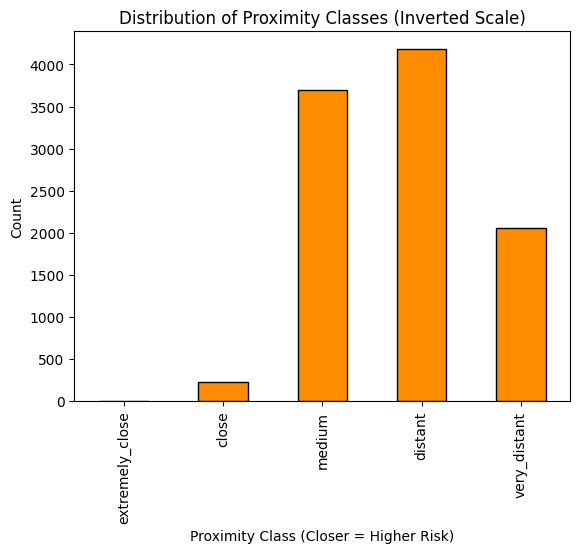

In [26]:
df_model["proximity_class"].value_counts().sort_index().plot(
    kind="bar", color="darkorange", edgecolor="black"
)
plt.title("Distribution of Proximity Classes (Inverted Scale)")
plt.xlabel("Proximity Class (Closer = Higher Risk)")
plt.ylabel("Count")
plt.show()

*  Velocity Classification
    + we have one measure of velocity -  `relative_velocity_mean`. 
    + As we can see below there is a very wide range of velocities. However the distribution is not as skewed as diamter and miss_distance so we will keep raw values for ML modelling and use Velocity class during dashboarding.
    

In [24]:
#max and min relative velocity (km/h - as this is the unit in the original data) 
df_model['relative_velocity_mean'].min().round(2), df_model['relative_velocity_mean'].max().round(2)

(646.32, 228242.24)

Velocity Class - Approx Speed 

* slow	0 – 54,000(km/h)
    * Slow relative motion
    * Typically associated with Earth-like orbits and longer observation windows.
* moderate	54,000 – 126,000(km/h)	
    * Typical NEO flyby velocities	
    * Well-observed and common.
* fast 126,000 – 252,000(km/h)	
    * High-velocity encounters	
    * less common.
* very fast	> 252,000(km/h)	
    * Unusually fast objects	
    * relatively rare.
    * There are no examples in our dataset so will not be implementing

In [35]:


# Define revised bins in km/h
velocity_bins = [0, 54000, 126000, df_model["relative_velocity_mean"].max()]
velocity_labels = ["slow", "moderate", "fast"]

# Apply binning
df_model["velocity_class"] = pd.cut(
    df_model["relative_velocity_mean"],
    bins=velocity_bins,
    labels=velocity_labels,
    include_lowest=True
)

# Check class distribution
print(df_model["velocity_class"].value_counts(dropna=False))

velocity_class
moderate    5106
slow        4893
fast         156
Name: count, dtype: int64


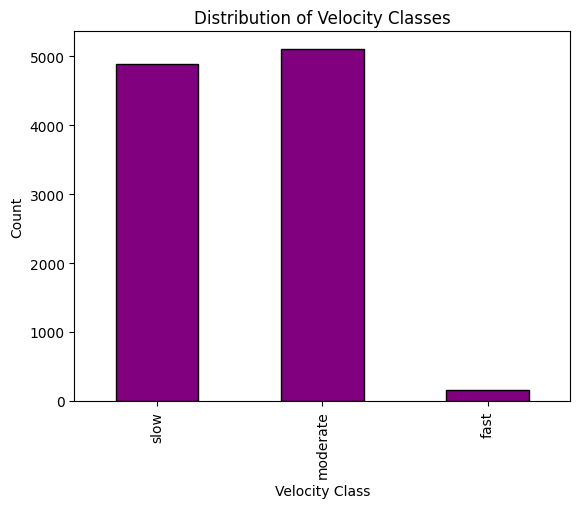

In [36]:
#plot class distribution
df_model["velocity_class"].value_counts().sort_index().plot(
    kind="bar", color="purple", edgecolor="black"
)
plt.title("Distribution of Velocity Classes")
plt.xlabel("Velocity Class")
plt.ylabel("Count")
plt.show()

* Brightness Classification
    * Inverted scale
    * Already well distributed
    * For use in Dashboard & ML Modelling(alternatively use inverted scale)

Class Brightness (H = Absolute Magnitude)
* very_bright H ≤ 12	 
    * large or highly reflective NEOs
    * Often well-observed or historically significant objects..
* bright 12 < H ≤ 16	
    * typically larger asteroids (hundreds of meters–km)
    * Common among known PHAs (potentially hazardous asteroids).
* moderate	16 < H ≤ 19
    * Medium sized NEOs
    * Typical discovery brightness range.
* dim	H > 19	
    * Fainter, smaller low albedo(reflectiveness) objects.
    * Often newer or shorter-arc discoveries.

In [42]:
# check absolute magnitude range(H) - max and min
df_model['absolute_magnitude_mean'].min().round(2), df_model['absolute_magnitude_mean'].max().round(2)

(9.23, 22.43)

In [ ]:
# bins matching  observed range (9.23 – 22.43)
brightness_bins = [df_model["absolute_magnitude_mean"].min(),  16, 19, df_model["absolute_magnitude_mean"].max()]
brightness_labels = [ "bright", "moderate", "dim"]
#merged "bright and "very_bright" as only 2 asteroids < 12
# Apply classification
df_model["brightness_class"] = pd.cut(
    df_model["absolute_magnitude_mean"],
    bins=brightness_bins,
    labels=brightness_labels,
    include_lowest=True
)

# Check distribution
print("Brightness Class Distribution:")
print(df_model["brightness_class"].value_counts(dropna=False))


Brightness Class Distribution:
brightness_class
dim         8161
moderate    1872
bright       122
Name: count, dtype: int64


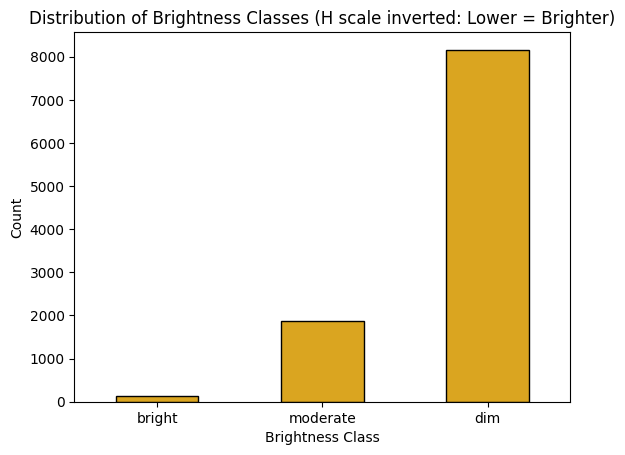

In [45]:
df_model["brightness_class"].value_counts().sort_index().plot(
    kind="bar",
    color="goldenrod",
    edgecolor="black"
)
plt.title("Distribution of Brightness Classes (H scale inverted: Lower = Brighter)")
plt.xlabel("Brightness Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

* Observation Classification
    * Currently very skewed
    * For use in Dashboard & ML Modelling(alternatively use inverted scale)

* Class	Observations (number)
    * single (1) -	One-off sighting
    * few (2–3)	- Minimal follow-up
    * some	(4–6) -	Basic tracking
    * many	(7–12)	Well tracked
    * extensive	(≥ 13)	Intensive tracking 

In [49]:
# df_model must contain 'observations' (integer count)
obs_bins = [0, 1, 3, 6, 12, df_model["observations"].max()]
obs_labels = ["single", "few", "some", "many", "extensive"]

df_model["observation_class"] = pd.cut(
    df_model["observations"], bins=obs_bins, labels=obs_labels, include_lowest=True
)

print(df_model["observation_class"].value_counts(dropna=False))

observation_class
few          3568
single       3560
some         1706
many         1115
extensive     206
Name: count, dtype: int64


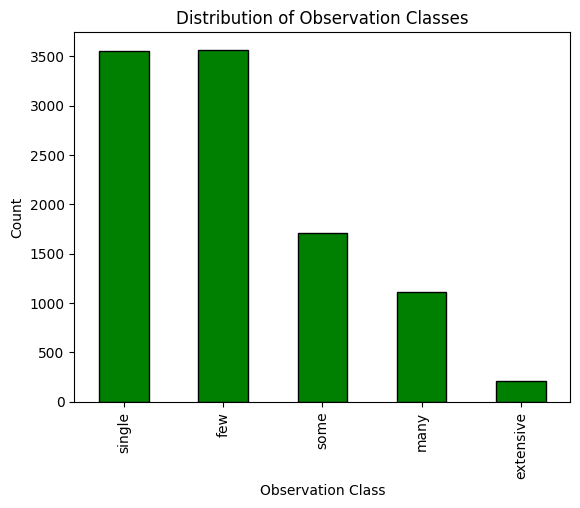

In [51]:
df_model['observation_class'].value_counts().sort_index().plot(
    kind="bar", color="green", edgecolor="black", title="Distribution of Observation Classes"
)
plt.xlabel("Observation Class")
plt.ylabel("Count")
plt.show()


While still right skewed, this gives a much better distribution and will reduce the amount of noise for our ML models.

---

### Check & Save modelled Dataset

In [52]:
df_model.columns, df_model.shape

(Index(['name', 'est_diameter_min', 'est_diameter_max',
        'relative_velocity_mean', 'miss_distance_mean', 'miss_distance_min',
        'absolute_magnitude_mean', 'hazardous', 'observations',
        'est_diameter_range', 'est_diameter_mean', 'est_diameter_min_log1p',
        'est_diameter_max_log1p', 'est_diameter_mean_log1p',
        'est_diameter_range_log1p', 'relative_velocity_mean_log1p',
        'miss_distance_mean_log1p', 'miss_distance_min_log1p', 'hazardous_enc',
        'diameter_class', 'proximity_class', 'velocity_class', 'velocity_kmh',
        'brightness_class', 'observation_class'],
       dtype='object'),
 (10155, 25))

In [53]:
#print model head rotate view
df_model.head(4).T


,0,1,2,3
name,(1983 LC),(1986 NA),(1988 NE),(1989 AZ)
est_diameter_min,0.342417,0.28481,0.402305,0.319562
est_diameter_max,0.765667,0.636854,0.89958,0.714562
relative_velocity_mean,60192.646491,51810.077045,22815.738845,55184.046572
miss_distance_mean,18476643.271,70052459.208572,65063306.320902,25604655.93738
miss_distance_min,10334476.5074,70052459.208572,65063306.320902,20219801.806052
absolute_magnitude_mean,19.45,19.85,19.1,19.6
hazardous,True,False,False,False
observations,2,1,1,2
est_diameter_range,0.42325,0.352044,0.497276,0.395


We can now save our model and move on to running our ML models on the data. (see `ML_Modelling.ipynb`)

In [54]:
#save features model to csv
df_model.to_csv("features_model.csv", index=False)